# Car Price Prediction
Pada kesempatan kali ini saya akan membangun model machine learning yang dapat memprediksi harga jual mobil. Oke, langsung saja kita mulai. 

# Baseline 
Always start with simple model (Emmanuel Ameisen, 2018)

## Import Library 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease, mean_loss_decrease

## Import Data

In [2]:
df = pd.read_csv("data/carprice.csv", index_col="ID")
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price
ID,,,,,,,,,,,,
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74
6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,3.50


In [3]:
df.shape

(5953, 12)

Data memiliki 5953 baris dan 12 kolom.

In [4]:
df.dtypes

Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage_kmpl         float64
Engine_CC            float64
Power_bhp            float64
Seats                float64
Price                float64
dtype: object

Seluruh tipe data telah sesuai.

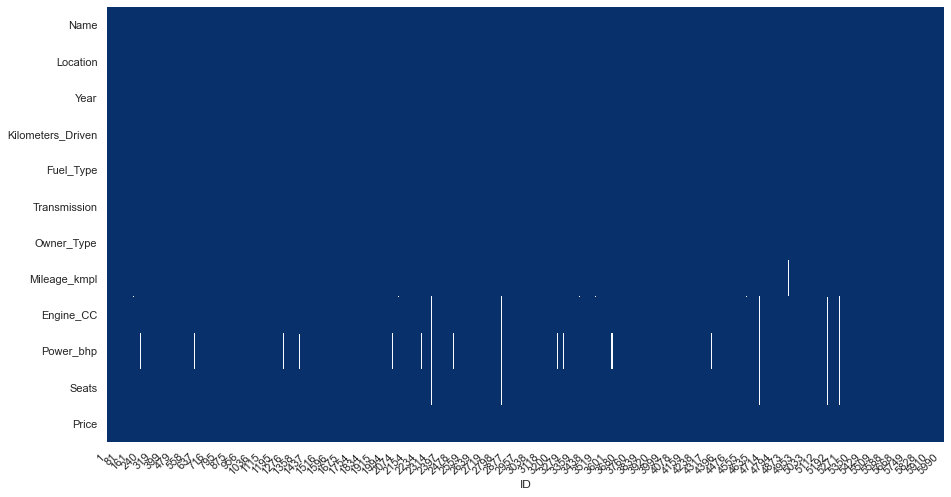

In [5]:
plot_missing_value(df)

In [6]:
# hapus fitur yg saat ini belum diperlukan
df.drop(columns='Name', axis=1, inplace=True)

In [7]:
df.shape

(5953, 11)

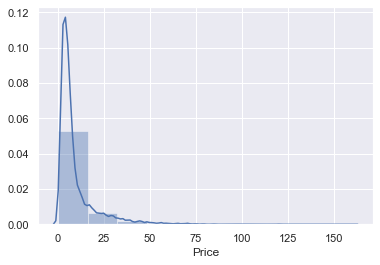

In [8]:
sns.distplot(df.Price, bins=10);

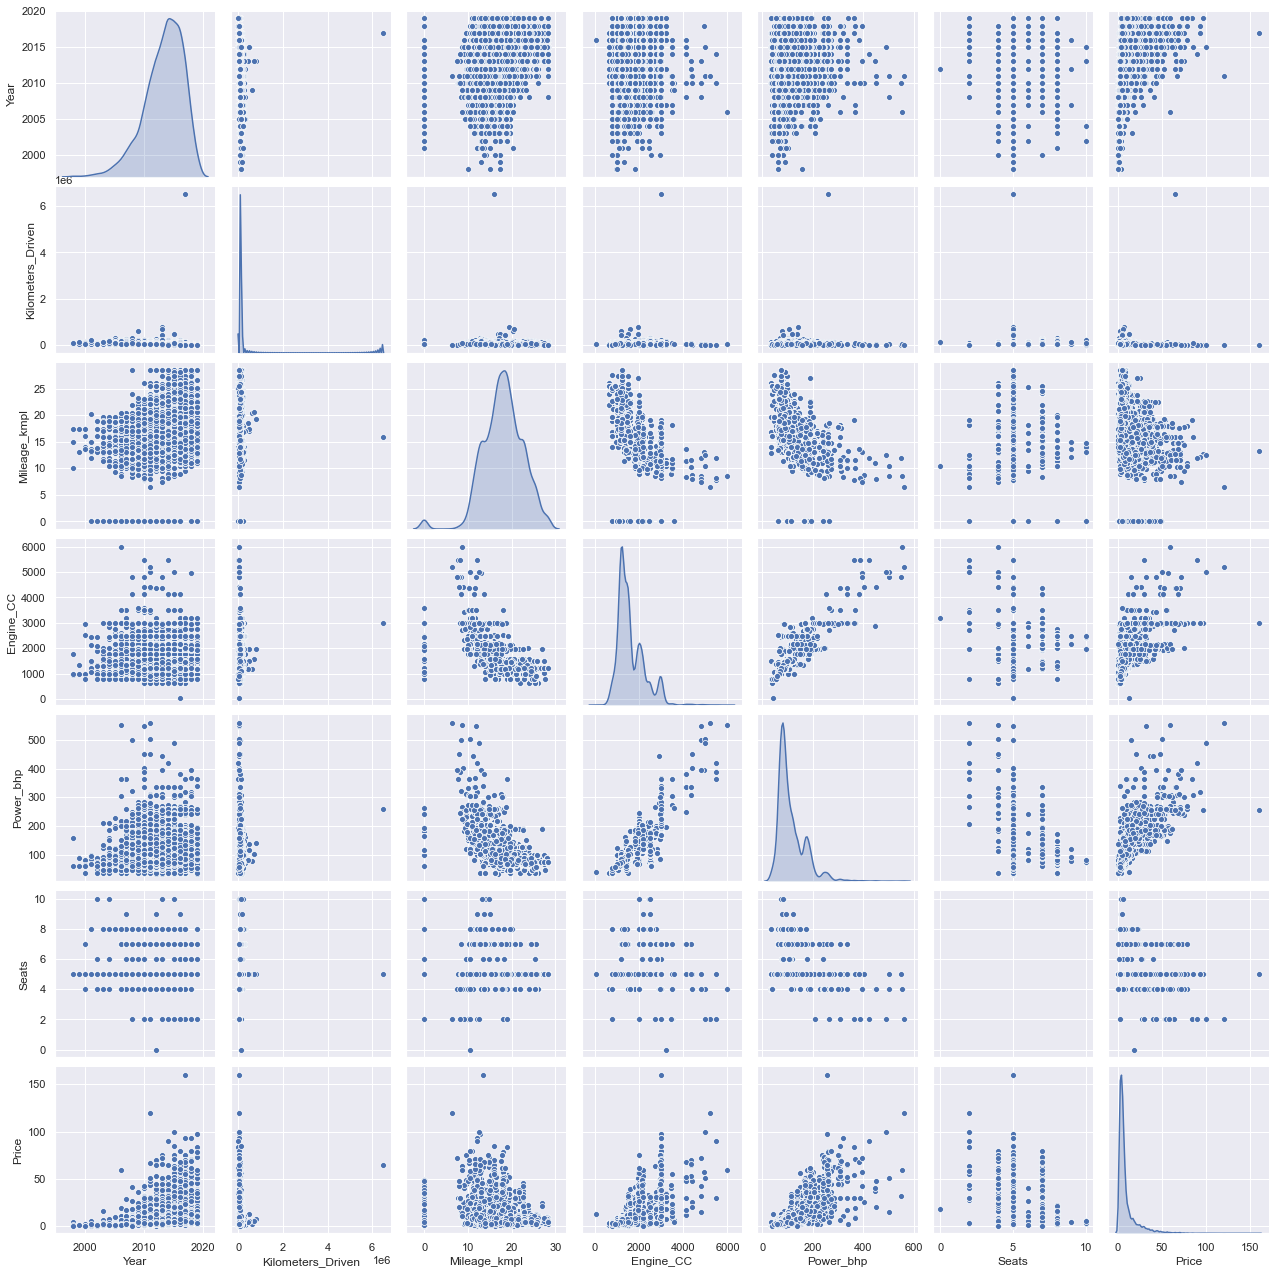

In [9]:
sns.pairplot(df, diag_kind='kde');

## Dataset Splitting

In [10]:
X = df.drop(columns="Price")
y = df.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4762, 10), (1191, 10), (4762,), (1191,))

## Modeling 

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning.space import Integer, Real
from sklearn.linear_model import ElasticNet

In [12]:
rsp.enet_params

{'algo__fit_intercept': [True, False],
 'algo__alpha': Real(low=-4, high=2, prior='log-uniform'),
 'algo__l1_ratio': Real(low=0, high=1, prior='uniform')}

In [13]:
X_train.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats
ID,,,,,,,,,,
4380,Coimbatore,2016,60913,Petrol,Manual,First,20.73,1373.0,91.1,5.0
2676,Kochi,2017,40459,Diesel,Manual,First,19.67,1582.0,126.2,5.0
647,Jaipur,2004,200000,Petrol,Manual,First,0.00,1086.0,NaN,5.0
5966,Hyderabad,2018,1048,Petrol,Manual,First,18.90,998.0,67.1,5.0
2198,Ahmedabad,2013,96000,Diesel,Manual,Second,23.50,1498.0,90.0,5.0


In [14]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['Year','Kilometers_Driven','Mileage_kmpl','Engine_CC','Power_bhp','Seats']),
    ('categoric', cat_pipe(encoder='onehot'), ['Location','Fuel_Type','Transmission','Owner_Type']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])


model = RandomizedSearchCV(pipeline, rsp.enet_params, cv=10, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   40.0s


{'algo__alpha': 0.18037506431281877, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.29627350570408245}
0.7078346331570662 0.6500412464316921 0.6520296253937494


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   44.0s finished


## Coba poly 

In [15]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['Year','Kilometers_Driven','Mileage_kmpl','Engine_CC','Power_bhp','Seats']),
    ('categoric', cat_pipe(encoder='onehot'), ['Location','Fuel_Type','Transmission','Owner_Type']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])


model = RandomizedSearchCV(pipeline, rsp.enet_poly_params, cv=10, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 454 tasks      | elapsed:  1.6min


{'algo__alpha': 0.09627001408471521, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.14808692995339992, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.7122244140142664 0.6486310322096365 0.6555255509286657


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.8min finished


## Evaluasi 

In [16]:
from jcopml.plot import plot_residual

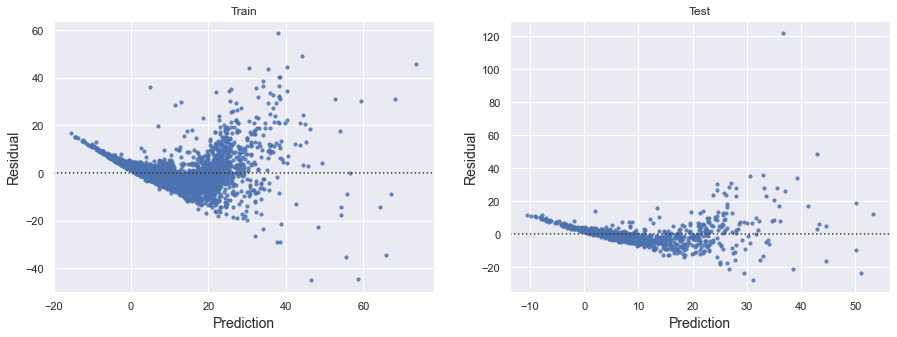

In [17]:
plot_residual(X_train, y_train, X_test, y_test, model)

Dari hasil residual plot di atas saya membaca pola bahwa sepertinya harus menggunakan model yang non linear. 

## Modeling 

In [18]:
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp
from sklearn.svm import SVR

In [19]:
gsp.svm_params

{'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [20]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust', ), ['Year','Kilometers_Driven','Mileage_kmpl','Engine_CC','Power_bhp','Seats']),
    ('categoric', cat_pipe(encoder='onehot'), ['Location','Fuel_Type','Transmission','Owner_Type']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])


model = GridSearchCV(pipeline, gsp.svm_params, cv=10, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:  1.9min finished


{'algo__C': 10.0, 'algo__gamma': 0.1}
0.8692907569381978 0.835261527826621 0.8314246832596819


Dari hasil baseline kita telah mendapatkan skor (R-square) yang cukup bagus.

In [21]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algo__C,param_algo__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
30,0.695761,0.012480,0.06240,9.536743e-08,10,0.1,"{'algo__C': 10.0, 'algo__gamma': 0.1}",0.743473,0.776417,0.850672,0.836005,0.824741,0.894576,0.821463,0.911841,0.858601,0.834826,0.835262,0.047281,1
37,0.556542,0.015222,0.05616,7.642440e-03,100,0.1,"{'algo__C': 100.0, 'algo__gamma': 0.1}",0.781936,0.804855,0.758486,0.834591,0.801464,0.805440,0.740990,0.827085,0.834900,0.796201,0.798595,0.029547,2
36,0.680583,0.028926,0.05928,6.239963e-03,100,0.01,"{'algo__C': 100.0, 'algo__gamma': 0.01}",0.750987,0.803513,0.813345,0.780011,0.777895,0.796010,0.716171,0.781149,0.829788,0.706781,0.775565,0.038060,3
23,0.733201,0.024167,0.05772,7.148839e-03,1,0.1,"{'algo__C': 1.0, 'algo__gamma': 0.1}",0.592665,0.635545,0.769633,0.701506,0.746007,0.812037,0.767030,0.779750,0.712645,0.719265,0.723608,0.064036,4
29,0.692641,0.007642,0.06084,4.680022e-03,10,0.01,"{'algo__C': 10.0, 'algo__gamma': 0.01}",0.540577,0.624158,0.579762,0.699026,0.679616,0.600134,0.714210,0.763255,0.591327,0.702153,0.649422,0.068155,5


## Evaluasi

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [23]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [24]:
print('MAE Train :', mean_absolute_error(y_train, y_pred_train))
print('MSE Train :', mean_squared_error(y_train, y_pred_train))
print('RMSE Train :', mean_squared_error(y_train, y_pred_train, squared=False))

MAE Train : 2.08934155870469
MSE Train : 16.02224608034237
RMSE Train : 4.002779794135867


In [25]:
print('MAE Test :', mean_absolute_error(y_test, y_pred_test))
print('MSE Test :', mean_squared_error(y_test, y_pred_test))
print('RMSE Test :', mean_squared_error(y_test, y_pred_test, squared=False))

MAE Test : 2.2763260985421345
MSE Test : 23.626226920221878
RMSE Test : 4.860681734100874


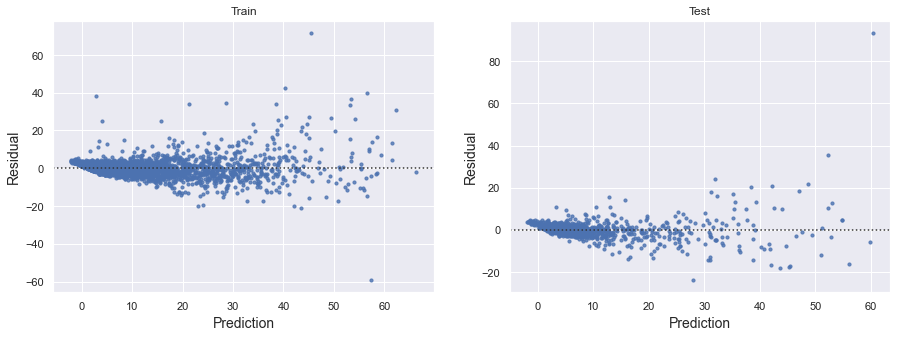

In [26]:
plot_residual(X_train, y_train, X_test, y_test, model)

Saya melihat ada pola kekurangan informasi sehingga model belum bisa bekerja secara maksimal.

## Coba cek datanya!

In [27]:
df_analisis = X_train.copy()
df_analisis['actual'] = y_train.copy()
df_analisis['pred'] = model.predict(X_train)
df_analisis['error'] = np.abs(df_analisis.actual - df_analisis.pred)
df_analisis.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,actual,pred,error
ID,,,,,,,,,,,,,
4380,Coimbatore,2016,60913,Petrol,Manual,First,20.73,1373.0,91.1,5.0,7.19,6.549086,0.640914
2676,Kochi,2017,40459,Diesel,Manual,First,19.67,1582.0,126.2,5.0,13.28,11.764035,1.515965
647,Jaipur,2004,200000,Petrol,Manual,First,0.00,1086.0,NaN,5.0,0.80,0.563150,0.236850
5966,Hyderabad,2018,1048,Petrol,Manual,First,18.90,998.0,67.1,5.0,4.70,7.233534,2.533534
2198,Ahmedabad,2013,96000,Diesel,Manual,Second,23.50,1498.0,90.0,5.0,3.50,2.888752,0.611248


In [28]:
df_analisis.sort_values('error', ascending=False).head(20)

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,actual,pred,error
ID,,,,,,,,,,,,,
5781,Delhi,2011,6500,Petrol,Automatic,Third,6.40,5204.0,560.00,2.0,120.00,45.515638,74.484362
3132,Kochi,2019,14298,Petrol,Automatic,First,13.33,2995.0,340.00,5.0,2.02,57.465128,55.445128
5535,Ahmedabad,2015,97003,Diesel,Automatic,First,15.87,2993.0,308.43,5.0,85.00,40.284272,44.715728
5919,Hyderabad,2015,8000,Petrol,Automatic,First,12.50,5000.0,488.10,2.0,100.00,56.587877,43.412123
1974,Coimbatore,2018,28060,Petrol,Automatic,First,12.05,2979.0,320.00,5.0,93.67,53.452668,40.217332
1460,Coimbatore,2008,69078,Petrol,Manual,First,0.00,NaN,NaN,NaN,40.88,2.760320,38.119680
4691,Bangalore,2014,3000,Petrol,Automatic,Second,12.00,5461.0,421.00,2.0,90.00,53.193169,36.806831
655,Mumbai,2017,10501,Petrol,Automatic,First,9.43,1999.0,237.40,5.0,75.00,38.432594,36.567406
2328,Chennai,2017,6500000,Diesel,Automatic,First,15.97,2993.0,258.00,5.0,65.00,28.643081,36.356919


Dari tabel di atas saya dapat menarik beberapa insight sebagai berikut : 
* Model kita kurang mampu melakukan prediksi dengan baik pada mobil-mobil dengan harga tinggi. 
* Kedepan sepertinya kita harus mengekstrak nama mobil dengan harapan dapat membantu model agar dapat melakukan prediksi lebih baik lagi. 
* Diantara mobil-mobil dengan harga yang tinggi ada keanehan karena ada mobil dengan spec bagus namun harga jual murah 2.02.

## Save Model

In [29]:
save_model(model.best_estimator_, "CarPrice_v1.pkl")

Model is pickled as model/CarPrice_v1.pkl
